In [4]:
#using Revise
#push!(LOAD_PATH,"../src/")
using ProgressBars
using ITensors
using PastaQ
using RandomMeas

In [5]:
N = 10
depth = 5
circuit    = randomcircuit(N, depth=depth)
noisemodel = (1 => ("depolarizing", (p = 0.02,)),2 => ("depolarizing", (p = 0.02,)))
ψ = Vector{MPS}()
ρ = Vector{MPO}()
for d in ProgressBar(1:depth, printing_delay=2)
        if d==1
            push!(ψ,runcircuit(circuit[1],cutoff=1e-4))
            push!(ρ,runcircuit(circuit[1];noise = noisemodel, cutoff=1e-4));
            global ξ = [firstind(ρ[1][i],tags="Site",plev=0) for i in 1:N]
            replace_siteinds!(ψ[1],ξ)
        else
            push!(ψ,runcircuit(ψ[d-1],circuit[d];cutoff=1e-4));  

            push!(ρ,runcircuit(ρ[d-1],circuit[d];noise = noisemodel, cutoff=1e-4));   
        end
end

println("state prepared in the `experiment")
println(maxlinkdim(ψ[depth]))
println(maxlinkdim(ρ[depth]))

0.0%┣                                                ┫ 0/5 [00:00<00:00, -0s/it]


state prepared in the `experiment
15
157


100.0%┣███████████████████████████████████████████████┫ 5/5 [00:01<00:00, 5it/s]
100.0%┣███████████████████████████████████████████████┫ 5/5 [00:01<00:00, 5it/s]


In [6]:
#Perform Randomized measurements
nu=100
NM=10000
Fs = zeros(Float64,depth)
FsCRM = zeros(Float64,depth)
for d in 1:depth
    data = [zeros(Int8,(NM,N)) for r in 1:nu]
    u = Vector{Vector{ITensor}}()
    P = Vector{ITensor}()
    P0 = Vector{ITensor}()
    for r in ProgressBar(1:nu, printing_delay=2)
                    push!(u,get_rotations(ξ,1)) #Haar rotations in A
                    #get_RandomMeas_MPO!(data[r],ρ[d],u[r],NM)
                    data[r] = get_RandomMeas(ρ[d],u[r],NM)
                    push!(P,get_Born(data[r],ξ))
                    ψu = apply(u[r],ψ[d])
                    push!(P0,flatten(get_Born_MPS(ψu)))
                    Fs[d] += get_overlap(P[r],P0[r],ξ,N)/nu
                    FsCRM[d] += (get_overlap(P[r],P0[r],ξ,N)-get_overlap(P0[r],P0[r],ξ,N)+1)/nu
    end
end

0.0%┣                                              ┫ 0/100 [00:00<00:00, -0s/it]
46.0%┣████████████████████▎                       ┫ 46/100 [00:02<00:02, 22it/s]
99.0%┣███████████████████████████████████████████▋┫ 99/100 [00:04<00:00, 24it/s]
100.0%┣██████████████████████████████████████████┫ 100/100 [00:04<00:00, 24it/s]
100.0%┣██████████████████████████████████████████┫ 100/100 [00:04<00:00, 24it/s]
0.0%┣                                              ┫ 0/100 [00:00<00:00, -0s/it]
53.0%┣███████████████████████▎                    ┫ 53/100 [00:02<00:02, 26it/s]
100.0%┣██████████████████████████████████████████┫ 100/100 [00:04<00:00, 27it/s]
100.0%┣██████████████████████████████████████████┫ 100/100 [00:04<00:00, 27it/s]
0.0%┣                                              ┫ 0/100 [00:00<00:00, -0s/it]
52.0%┣██████████████████████▉                     ┫ 52/100 [00:02<00:02, 25it/s]
88.0%┣██████████████████████████████████████▊     ┫ 88/100 [00:04<00:01, 21it/s]
100.0%┣█████████████████████

In [7]:
#Fidelity
F = [real(inner(ψ[d]',ρ[d],ψ[d])) for d in 1:depth];
@show F;

F = [0.9225128456710339, 0.8575681406092348, 0.7818203528264411, 0.7229794798438735, 0.6548780702292758]


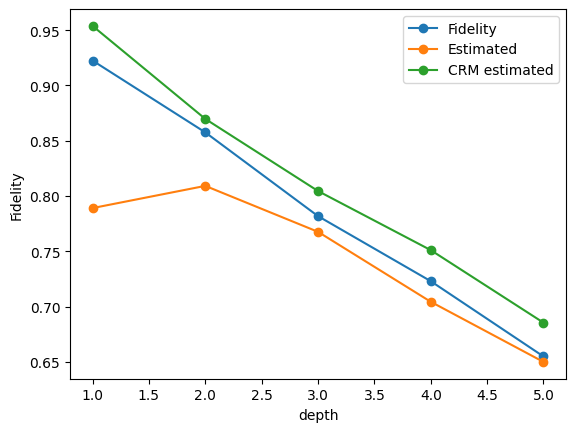

PyObject <matplotlib.legend.Legend object at 0x7f4d0bd9a090>

In [8]:
using PyPlot
PyPlot.plot(1:depth,F,"-o")
PyPlot.plot(1:depth,Fs,"-o")
PyPlot.plot(1:depth,FsCRM,"-o")
xlabel("depth")
ylabel("Fidelity")
legend(["Fidelity","Estimated", "CRM estimated"])